In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import PTA
print(PTA.__version__)

from IPython.display import display

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="ipyrad")
print(len(ipyclient))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.0.11
40


## Generate simulations for proportional msfs

In [5]:
# sorted
model = PTA.DemographicModel("expanding-sorted-props")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 14)
model.set_param("nsamps", 8)
model.set_param("N_e", "2e5-5e6")
model.set_param("tau", "1e4-1e6")
model.set_param("epsilon", "0.01-0.1")
model.set_param("length", "150")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 500)
model.set_param("recoms_per_gen", 0)
model.set_param("muts_per_gen", 6.6e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = True
model._hackersonly["proportional_msfs"] = True
model.simulate(nsims=40000, quiet=False, verbose=False, ipyclient=ipyclient)

------- PTA params file (v.0.0.11)----------------------------------------------
expanding-sorted-props ## [0] [simulation_name]: The name of this simulation scenario
/media/4TB/isaac/PTA-EasternSnakes/analysis/simulations ## [1] [project_dir]: Where to save files
14                   ## [2] [npops]: Number of populations undergoing co-demographic processes
8                    ## [3] [nsamps]: Numbers of samples for each populations
200000-5000000       ## [4] [N_e]: Effective population size of the contemporary population
10000-1000000        ## [5] [tau]: Time of demographic change
0.01-0.1             ## [6] [epsilon]: Magnitude of demographic change
0                    ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
150                  ## [8] [length]: Length in bp of each independent genomic region to simulate
500,500,500,500,500,500,500,500,500,500,500,500,500,500 ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ##

In [ ]:
# unsorted
model = PTA.DemographicModel("expanding-unsorted-props")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 14)
model.set_param("nsamps", 8)
model.set_param("N_e", "2e5-5e6")
model.set_param("tau", "1e4-1e6")
model.set_param("epsilon", "0.01-0.1")
model.set_param("length", "150")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 500)
model.set_param("recoms_per_gen", 0)
model.set_param("muts_per_gen", 6.6e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = False
model._hackersonly["proportional_msfs"] = True
model.simulate(nsims=40000, quiet=False, verbose=False, ipyclient=ipyclient)

## Classification cross-validation
RF is fast

In [3]:
# The 'reference table'
sorted_sim_df = pd.read_csv("analysis/simulations/expanding-sorted-props-SIMOUT.csv", sep=" ")
print(len(sorted_sim_df))
# This is a input
synthetic_community = pd.DataFrame(sorted_sim_df.loc[0]).T.drop(PTA.inference.default_targets, axis=1)

## RF parameters from a cv_search process which took like a day, don't want to redo it.
rf_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': 70,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
rf_sorted_cl = PTA.inference.Classifier(empirical_df=synthetic_community,
                                       sims=sorted_sim_df,
                                       algorithm="rf")
# Set GB model params
rf_sorted_cl.set_params(rf_params)
# Set the target for classification
rf_sorted_cl.set_targets(["zeta_e"])
# Run quickly to set up the model
rf_sorted_cl.predict(select_features=False, param_search=False, quick=True, verbose=True)
# Do the cross validation prediction
cv_preds = rf_sorted_cl.cross_val_predict(cv=3,
                    quick=True,
                    verbose=True)

280040
Predict() started: 2023-05-12 15:53:14.918214
Predict() finished: 2023-05-12 15:55:13.348581
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10106
           1       0.36      0.64      0.46     20243
           2       0.29      0.20      0.23     19851
           3       0.29      0.27      0.28     19947
           4       0.33      0.33      0.33     19892
           5       0.36      0.39      0.37     19942
           6       0.38      0.41      0.39     19803
           7       0.34      0.37      0.35     20169
           8       0.29      0.30      0.30     20141
           9       0.26      0.19      0.22     19944
          10       0.26      0.20      0.23     19923
          11       0.27      0.22      0.24     20184
          12       0.31      0.28      0.29     19803
          13       0.34      0.57      0.42     20018
          14       0.48      0.34      0.40     10074

    accuracy                      

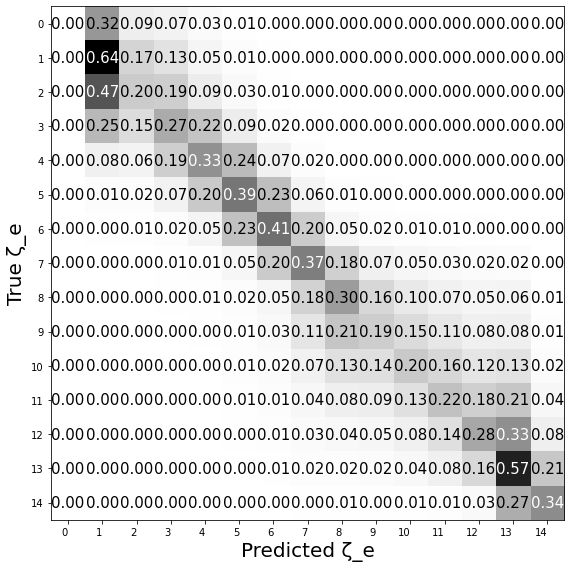

In [13]:
ax = rf_sorted_cl.plot_confusion_matrix(normalize=True)

## Predict zeta from empirical data

In [8]:
%%time
# Load msfs and reshape it into a format the ML stuff expects
sorted_expanding_msfs = pd.read_csv("analysis/msfs/proj8-sort-props.msfs", index_col=0)
sorted_expanding_msfs = pd.DataFrame(sorted_expanding_msfs.to_numpy().ravel(order="F"), index=synthetic_community.columns).T
display(sorted_expanding_msfs)

rf_sorted_cl.set_data(sorted_expanding_msfs)
rf_class_est = rf_sorted_cl.predict(select_features=False,\
                                    param_search=False,\
                                    quick=True,\
                                    verbose=True)
#axs = gb_sorted_cl.plot_feature_importance()
rf_class_est

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]],pop6-[[7_1]],pop6-[[6_2]],pop6-[[5_3]],pop6-[[4_4]],pop7-[[7_1]],pop7-[[6_2]],pop7-[[5_3]],pop7-[[4_4]],pop8-[[7_1]],pop8-[[6_2]],pop8-[[5_3]],pop8-[[4_4]],pop9-[[7_1]],pop9-[[6_2]],pop9-[[5_3]],pop9-[[4_4]],pop10-[[7_1]],pop10-[[6_2]],pop10-[[5_3]],pop10-[[4_4]],pop11-[[7_1]],pop11-[[6_2]],pop11-[[5_3]],pop11-[[4_4]],pop12-[[7_1]],pop12-[[6_2]],pop12-[[5_3]],pop12-[[4_4]],pop13-[[7_1]],pop13-[[6_2]],pop13-[[5_3]],pop13-[[4_4]]
0,0.733887,0.239843,0.174959,0.080827,0.712452,0.230946,0.173487,0.078543,0.706672,0.226319,0.152894,0.068655,0.706339,0.223852,0.147902,0.063709,0.675971,0.211012,0.133761,0.057377,0.673302,0.184814,0.119381,0.055943,0.663604,0.181769,0.109614,0.051165,0.654406,0.172104,0.107888,0.050682,0.652572,0.171509,0.106567,0.048601,0.59785,0.171188,0.106027,0.047301,0.56207,0.166222,0.105484,0.04691,0.554598,0.159658,0.096186,0.046273,0.513267,0.131381,0.093394,0.040277,0.508127,0.123018,0.089673,0.037766


Predict() started: 2023-05-12 16:00:50.922708
CPU times: user 1.42 s, sys: 258 ms, total: 1.67 s
Wall time: 1.53 s


(          zeta_e
 estimate       5,
               0        1        2         3         4         5         6   \
 zeta_e  0.022431  0.05073  0.08237  0.159788  0.097294  0.176623  0.112049   
 
              7         8         9         10        11        12        13  \
 zeta_e  0.07039  0.088552  0.066342  0.023983  0.038094  0.008287  0.002644   
 
               14  
 zeta_e  0.000423  )

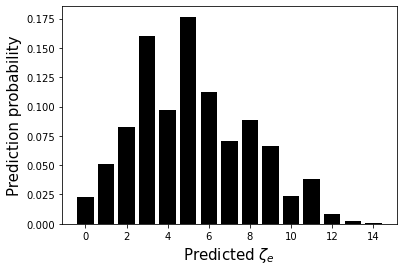

In [123]:
plt.bar(np.arange(15), rf_class_est[1].values[0], color='black')
plt.xlabel(r'Predicted $\zeta_{e}$', fontsize=15)
plt.ylabel("Prediction probability", fontsize=15)
#plt.margins(0.2)
plt.savefig('figure1.pdf', bbox_inches='tight', pad_inches=0.05)

## Hackish posterior predictive check

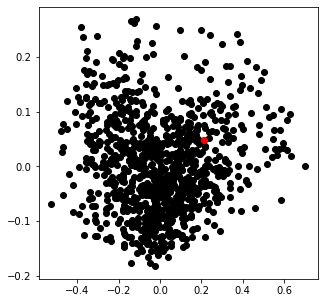

In [12]:
from sklearn.decomposition import PCA

estimated_zeta = 5

dat = sorted_sim_df[sorted_sim_df["zeta_e"] == estimated_zeta].iloc[:1000, 23:]
dat = pd.concat([sorted_expanding_msfs, dat])

pca = PCA(n_components=2)
pcs = pca.fit_transform(dat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pcs[:, 0], pcs[:, 1], c='black')
## Plot the observed ss in red
ax.scatter(pcs[:, 0][0], pcs[:, 1][0], c='r')

## Parameter estimation

Removed invariant targets. Retained: ['t_s', 'omega', 'taus_mean']
Predict() started: 2023-05-13 17:47:38.517102
Predict() finished: 2023-05-13 17:49:26.597007
                         MAE         RMSE    vscore        R2
t_s                 0.026071     0.000138  0.474591  0.474590
taus_mean           0.009193     0.000050  0.429176  0.429173
taus_std            0.003834     0.000021  0.141899  0.141898
omega               0.005111     0.000029  0.376584  0.376580
epsilons_mean       0.009148     0.000050  0.590561  0.590555
epsilons_std        0.003526     0.000019  0.236655  0.236647
Ne_s_mean      322372.062976  1786.058966  0.203482  0.203482
Ne_s_std       150595.881025   831.726670  0.116709  0.116685
CPU times: user 1h 10min 12s, sys: 27.4 s, total: 1h 10min 39s
Wall time: 9min 15s


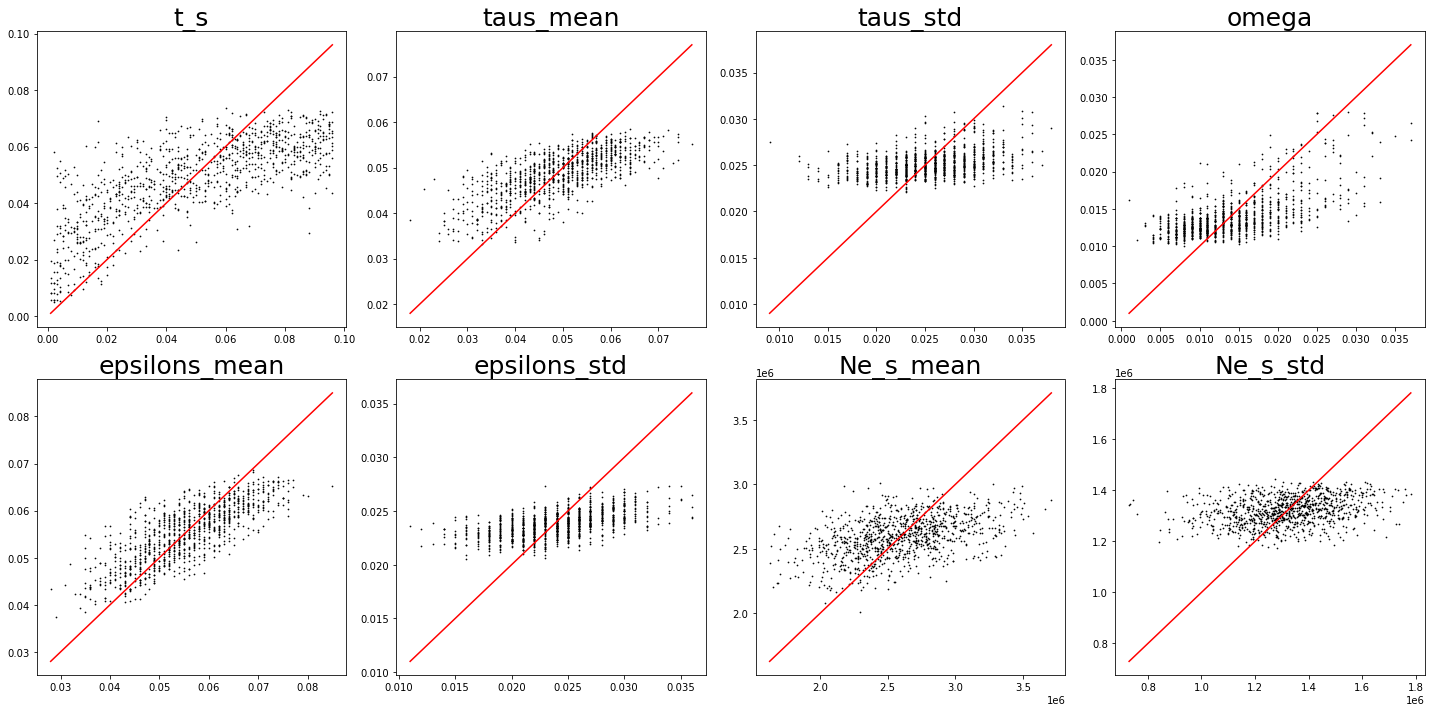

In [49]:
%%time
pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"].between(3, 5)]

rf_rgr = PTA.inference.Regressor(empirical_df=synthetic_community,\
                                sims=pruned_sorted_df,\
                                algorithm="rf",\
                                verbose=True)
rf_rgr.set_params(rf_params)
rf_rgr.set_targets(["t_s", "taus_mean", "taus_std", "omega", "epsilons_mean",
                       "epsilons_std", "Ne_s_mean", "Ne_s_std"])
rf_rgr.predict(select_features=False,\
            param_search=False,\
            quick=False,\
            verbose=True)
rg_rgr_preds = rf_rgr.cross_val_predict(verbose=True)
ax = rf_rgr.plot_cv_predictions(figsize=(20,10), figdims=(2,4))

## Predict params from empirical data

In [50]:
%%time
from sklearn.ensemble import RandomForestRegressor

params = ["t_s", "taus_mean", "taus_std", "omega", "epsilons_mean", "epsilons_std", "Ne_s_mean", "Ne_s_std"]

pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"].between(3, 6)]

X = pruned_sorted_df[sorted_expanding_msfs.columns]
y = pruned_sorted_df[params]

rf = RandomForestRegressor(**rf_params)
rf.fit(X, y)
## Prediction from pruned simulations
rf_param_est = pd.DataFrame(rf.predict(sorted_expanding_msfs), columns=params)
rf_param_est

CPU times: user 1h 35min 53s, sys: 7.85 s, total: 1h 36min
Wall time: 2min 28s


,t_s,taus_mean,taus_std,omega,epsilons_mean,epsilons_std,Ne_s_mean,Ne_s_std
0,0.036966,0.042655,0.026146,0.017275,0.061228,0.022666,2.584039e+06,1.432614e+06


In [16]:
rf_param_est

,t_s,taus_mean,taus_std,omega,epsilons_mean,epsilons_std,Ne_s_mean,Ne_s_std
0,59516.401301,75813.88311,47359.759216,31218.745558,0.06131,0.022957,2.564720e+06,1.436402e+06


## Prediction intervals

In [95]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for pred in model.estimators_:
        preds.append(pred.predict(X))
        err_down = np.percentile(preds, (100 - percentile) / 2. , axis=0)[0]
        err_up = np.percentile(preds, 100 - (100 - percentile) / 2., axis=0)[0]
    return err_down, err_up

err_down, err_up = pred_ints(rf, sorted_expanding_msfs)
pred_intervals = pd.DataFrame(np.array([err_down, rf_param_est.values[0], err_up]), columns=params)
pred_intervals

,t_s,taus_mean,taus_std,omega,epsilons_mean,epsilons_std,Ne_s_mean,Ne_s_std
0,0.009281,0.032249,0.022000,0.010857,0.050998,0.018249,2.009468e+06,1.200743e+06
1,0.036966,0.042655,0.026146,0.017275,0.061228,0.022666,2.584039e+06,1.432614e+06
2,0.070000,0.055008,0.030500,0.024902,0.070000,0.027429,3.182292e+06,1.652124e+06


In [94]:
# 50% Prediction intervals
display(pred_intervals["Ne_s_mean"] * pred_intervals["t_s"] / 3)
display(pred_intervals["Ne_s_mean"] * pred_intervals["taus_mean"] / 3)
pred_intervals

0    19114.155701
1    31840.791173
2    44602.236363
dtype: float64

0    30364.996492
1    36740.302659
2    43539.005619
dtype: float64

,t_s,taus_mean,taus_std,omega,epsilons_mean,epsilons_std,Ne_s_mean,Ne_s_std
0,0.024333,0.038656,0.024667,0.014600,0.057885,0.021000,2.356540e+06,1.357157e+06
1,0.036966,0.042655,0.026146,0.017275,0.061228,0.022666,2.584039e+06,1.432614e+06
2,0.047514,0.046381,0.027636,0.019644,0.064750,0.024204,2.816160e+06,1.505012e+06


In [96]:
# 95% prediction intervals
display(pred_intervals["Ne_s_mean"] * pred_intervals["t_s"] / 3)
display(pred_intervals["Ne_s_mean"] * pred_intervals["taus_mean"] / 3)
pred_intervals

0     6216.859049
1    31840.791173
2    74253.490125
dtype: float64

0    21600.947104
1    36740.302659
2    58350.867657
dtype: float64

,t_s,taus_mean,taus_std,omega,epsilons_mean,epsilons_std,Ne_s_mean,Ne_s_std
0,0.009281,0.032249,0.022000,0.010857,0.050998,0.018249,2.009468e+06,1.200743e+06
1,0.036966,0.042655,0.026146,0.017275,0.061228,0.022666,2.584039e+06,1.432614e+06
2,0.070000,0.055008,0.030500,0.024902,0.070000,0.027429,3.182292e+06,1.652124e+06


## Trash below here

In [45]:
%%time
from sklearn.model_selection import cross_val_predict

params = ["t_s", "taus_mean", "taus_std", "omega", "epsilons_mean", "epsilons_std", "Ne_s_mean", "Ne_s_std"]

sorted_sim_df = pd.read_csv("analysis/simulations/expanding-sorted-props-SIMOUT.csv", sep=" ")
pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"].between(3, 6)]

X = pruned_sorted_df[sorted_expanding_msfs.columns]
y = pruned_sorted_df[params]

rf = RandomForestRegressor(**rf_params)
rf_rgr_preds = cross_val_predict(rf, X, y, cv=3, n_jobs=-1)
# Hack the cv predictions into the PTA.Regressor class to get pretty plots
rf_rgr.cv_preds = pd.DataFrame(rf_rgr_preds, columns=rf_rgr.targets)
ax = rf_rgr.plot_cv_predictions(figsize=(20,10), figdims=(2,4), n_cvs=50000)


CPU times: user 1.63 s, sys: 25 s, total: 26.6 s
Wall time: 4min 56s


In [97]:
sorted_sim_df

,zeta,zeta_e,psi,t_s,omega,taus_mean,taus_std,taus_skewness,taus_kurtosis,taus_median,taus_iqr,epsilons_mean,epsilons_std,epsilons_skewness,epsilons_kurtosis,epsilons_median,epsilons_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]],pop6-[[7_1]],pop6-[[6_2]],pop6-[[5_3]],pop6-[[4_4]],pop7-[[7_1]],pop7-[[6_2]],pop7-[[5_3]],pop7-[[4_4]],pop8-[[7_1]],pop8-[[6_2]],pop8-[[5_3]],pop8-[[4_4]],pop9-[[7_1]],pop9-[[6_2]],pop9-[[5_3]],pop9-[[4_4]],pop10-[[7_1]],pop10-[[6_2]],pop10-[[5_3]],pop10-[[4_4]],pop11-[[7_1]],pop11-[[6_2]],pop11-[[5_3]],pop11-[[4_4]],pop12-[[7_1]],pop12-[[6_2]],pop12-[[5_3]],pop12-[[4_4]],pop13-[[7_1]],pop13-[[6_2]],pop13-[[5_3]],pop13-[[4_4]]
0,0.565,8,1,0.034,0.007,0.041,0.017,0.550,-0.718,0.034,0.019,0.040,0.030,0.639,-1.230,0.016,0.044,3090312.500,1198314.389,-0.684,-0.750,3468557.5,1216298.00,0.862,0.172,0.077,0.020,0.857,0.169,0.053,0.019,0.850,0.118,0.048,0.019,0.846,0.114,0.046,0.019,0.846,0.112,0.045,0.018,0.837,0.112,0.043,0.018,0.832,0.111,0.042,0.018,0.831,0.110,0.041,0.018,0.830,0.108,0.041,0.017,0.828,0.104,0.041,0.015,0.824,0.098,0.038,0.014,0.812,0.096,0.034,0.012,0.764,0.091,0.029,0.012,0.742,0.088,0.027,0.010
1,0.576,8,1,0.093,0.010,0.073,0.027,-1.029,-0.234,0.093,0.032,0.057,0.019,0.087,1.192,0.055,0.000,3061629.571,1263563.998,0.038,-1.241,3127648.5,1917290.00,0.745,0.224,0.108,0.041,0.741,0.211,0.097,0.035,0.741,0.184,0.081,0.034,0.740,0.177,0.081,0.034,0.736,0.175,0.080,0.032,0.732,0.172,0.079,0.032,0.729,0.170,0.079,0.031,0.727,0.163,0.077,0.031,0.722,0.160,0.076,0.030,0.721,0.159,0.073,0.029,0.714,0.159,0.073,0.027,0.705,0.157,0.072,0.027,0.646,0.153,0.070,0.026,0.638,0.151,0.068,0.025
2,0.029,0,0,0.062,0.016,0.051,0.028,-0.103,-1.355,0.060,0.047,0.058,0.023,-0.204,-0.613,0.062,0.030,1976983.571,1330375.200,0.257,-1.315,1827378.0,2565377.00,0.780,0.248,0.174,0.108,0.734,0.228,0.145,0.061,0.729,0.220,0.129,0.057,0.717,0.207,0.124,0.056,0.693,0.202,0.113,0.046,0.689,0.192,0.113,0.041,0.688,0.184,0.104,0.039,0.685,0.183,0.093,0.038,0.648,0.182,0.092,0.037,0.631,0.182,0.087,0.037,0.627,0.172,0.079,0.035,0.591,0.169,0.075,0.028,0.546,0.140,0.058,0.025,0.526,0.140,0.052,0.021
3,0.045,1,0,0.011,0.015,0.040,0.024,0.441,-1.030,0.037,0.033,0.049,0.025,0.556,-0.870,0.040,0.031,2836925.786,1198731.849,-0.134,-0.386,2797577.0,1545536.25,0.805,0.252,0.163,0.082,0.782,0.208,0.163,0.080,0.772,0.208,0.128,0.078,0.743,0.199,0.103,0.046,0.743,0.182,0.098,0.039,0.742,0.178,0.090,0.038,0.741,0.168,0.086,0.038,0.705,0.164,0.085,0.037,0.695,0.151,0.078,0.033,0.693,0.141,0.067,0.030,0.687,0.139,0.067,0.030,0.549,0.136,0.059,0.021,0.547,0.129,0.059,0.021,0.543,0.124,0.040,0.016
4,0.341,5,1,0.071,0.015,0.052,0.028,-0.756,-1.036,0.066,0.044,0.031,0.023,1.333,1.047,0.019,0.027,3242601.071,1070437.854,-0.174,-0.706,3288013.5,1326365.25,0.842,0.200,0.149,0.069,0.833,0.195,0.112,0.046,0.826,0.190,0.107,0.033,0.821,0.186,0.084,0.032,0.817,0.185,0.082,0.021,0.813,0.144,0.071,0.021,0.813,0.138,0.042,0.013,0.811,0.138,0.039,0.013,0.723,0.136,0.039,0.011,0.722,0.134,0.039,0.010,0.702,0.129,0.039,0.009,0.683,0.124,0.036,0.009,0.657,0.123,0.032,0.008,0.591,0.117,0.031,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,0.998,14,1,0.088,0.000,0.088,0.000,0.000,-3.000,0.088,0.000,0.023,0.000,0.000,-3.000,0.023,0.000,2740855.286,1378464.371,-0.228,-1.015,2805703.5,2202911.25,0.812,0.143,0.054,0.022,0.810,0.140,0.052,0.021,0.808